In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import scipy
from tqdm import tqdm
import h5py

import calculation.MeanFieldv2 as MFv2
import calculation.CurrentMeirv2 as CsMv2
import calculation.SusceptibilitySimpv2 as Susceptv2
import settings.Constants as const

In [2]:
saddleFile = "h5_output_data/VT-space_lowV_V2_extra.hdf5"
shotFile = "h5_output_data/CurrentNoiseVT_results_lowV_V2_extra.hdf5"


##! Read data from the hdf5 file
with h5py.File(saddleFile, 'r') as f:
    domain = f['VTSpace/domain'][:]
    DRDataOne = f['VTSpace/DRDataOne'][:]
    DKDataOne = f['VTSpace/DKDataOne'][:]


with h5py.File(shotFile, 'r') as f:
    retardedNonIntOne = f['ShotNoise/retardedNonIntOne'][:]/100
    keldyshNonIntOne = f['ShotNoise/keldyshNonIntOne'][:]/100
    retardedIntOne = f['ShotNoise/retardedIntOne'][:]
    keldyshIntOne = f['ShotNoise/keldyshIntOne'][:]
    
    domainOne = f['ShotNoise/domainOne'][:]
    dominZero = f['ShotNoise/domainZero'][:]
    
    

In [3]:
saddleFile1 = "h5_output_data/VT-space_lowV_V2.hdf5"
shotFile1 = "h5_output_data/CurrentNoiseVT_results_lowV_V2.hdf5"


##! Read data from the hdf5 file
with h5py.File(saddleFile1, 'r') as f:
    domain1 = f['VTSpace/domain'][:]
    DRDataOne1 = f['VTSpace/DRDataOne'][:]
    DKDataOne1 = f['VTSpace/DKDataOne'][:]


with h5py.File(shotFile1, 'r') as f:
    retardedNonIntOne1 = f['ShotNoise/retardedNonIntOne'][:]/100
    keldyshNonIntOne1 = f['ShotNoise/keldyshNonIntOne'][:]/100
    retardedIntOne1 = f['ShotNoise/retardedIntOne'][:]
    keldyshIntOne1 = f['ShotNoise/keldyshIntOne'][:]
    
    domainOne1 = f['ShotNoise/domainOne'][:]
    dominZero1 = f['ShotNoise/domainZero'][:]

In [4]:

retardedTotOne = retardedNonIntOne.real - 2*retardedIntOne.imag
keldyshTotOne = keldyshNonIntOne.real - keldyshIntOne.imag

retardedTotOne1 = retardedNonIntOne1.real - 2*retardedIntOne1.imag
keldyshTotOne1 = keldyshNonIntOne1.real - keldyshIntOne1.imag

In [5]:


FauxPlusTotal = retardedTotOne[:,1]/keldyshTotOne[:,1]
FauxMinusTotal = retardedTotOne[:,0]/keldyshTotOne[:,0]
dFomegaTotal = (FauxPlusTotal - FauxMinusTotal)/(2*2e-3)


slopRetarded = (retardedTotOne[:,1] - retardedTotOne[:,0])/(2*2e-3)


FauxPlusTotal1 = retardedTotOne1[:,1]/keldyshTotOne1[:,1]
FauxMinusTotal1 = retardedTotOne1[:,0]/keldyshTotOne1[:,0]
dFomegaTotal1 = (FauxPlusTotal1 - FauxMinusTotal1)/(2*2e-3)


slopRetarded1 = (retardedTotOne1[:,1] - retardedTotOne1[:,0])/(2*2e-3)



In [6]:
voltageSpace = domain[1:,1]
TvalueSpace = domain[1:,-1]
TeffRPA = 0.5/dFomegaTotal[1:]/2

x = voltageSpace
y = TvalueSpace
z = TeffRPA


mask_neg = np.logical_and(TeffRPA < 0.0, voltageSpace < 0.2)

x = voltageSpace[mask_neg]
y = TvalueSpace[mask_neg]
z = TeffRPA[mask_neg]

idx_flip = [-30, -44, -57, -69, -82] + [-83 - 12 * i for i in range(1,19)]

V_flip = x[idx_flip]
T_flip = y[idx_flip]
z_flip = z[idx_flip]



voltageSpace1 = domain1[1:,1]
TvalueSpace1 = domain1[1:,-1]
TeffRPA1 = 0.5/dFomegaTotal1[1:]/2

x1 = voltageSpace1
y1 = TvalueSpace1
z1 = TeffRPA1


mask_neg1 = np.logical_and(TeffRPA1 < 0.0, voltageSpace1 < 0.2)

x1 = voltageSpace1[mask_neg1]
y1 = TvalueSpace1[mask_neg1]
z1 = TeffRPA1[mask_neg1]

idx_flip = [-23,-41,-56,-69,-81,-92,-102,-111,-119,-127,-134]

V_flip1 = x1[idx_flip]
T_flip1 = y1[idx_flip]
z_flip1 = z1[idx_flip]




In [7]:


lambdaSamples = np.array([1.0])

phiConstantInit = 0.5
phiLambdaInit = 0.9
couplingValue = 0.7

def computeSaddlePoint(lambdaValue, Tvalue, voltageValue, pbar=None):
    result = scipy.optimize.root(MFv2.computeMFLambda, phiConstantInit, args=(lambdaValue, voltageValue, Tvalue, MFv2.Impy, couplingValue), method='lm', tol=1e-6)
    saddle_point = result.x[0]
    
    return saddle_point



In [8]:


hstep = 1e-5
omegaSpace = np.array([1e-5])

PiR = np.zeros((len(T_flip)), dtype=np.complex128)
PiR1 = np.zeros((len(T_flip1)), dtype=np.complex128)

lambdaUpper = lambdaSamples[0]

pbar = tqdm(total=len(T_flip)+len(T_flip1), desc='Computing PiR')


for i in range(len(T_flip1)):
    Tvalue = T_flip1[i]
    voltageValue = V_flip1[i]
    phiValue = computeSaddlePoint(lambdaUpper, Tvalue, voltageValue)
    PiR1[i:] = Susceptv2.computePiR(omegaSpace, lambdaUpper, phiValue, voltageValue, couplingValue, Tvalue=Tvalue)
    pbar.update(1)


for i in range(len(T_flip)):
    Tvalue = T_flip[i]
    voltageValue = V_flip[i]
    phiValue = computeSaddlePoint(lambdaUpper, Tvalue, voltageValue)
    PiR[i:] = Susceptv2.computePiR(omegaSpace, lambdaUpper, phiValue, voltageValue, couplingValue, Tvalue=Tvalue)
    pbar.update(1)


pbar.close()


Computing PiR:   0%|          | 0/34 [00:00<?, ?it/s]

Computing PiR: 100%|██████████| 34/34 [00:04<00:00,  8.31it/s]


In [9]:
def computeXR(PiRdata, lambdaValue):
    den = 1.0 - PiRdata/(2.0*lambdaValue)
    return PiRdata*np.reciprocal(den)/(2.0*lambdaValue**2)


XR = computeXR(PiR, lambdaUpper)
XR1 = computeXR(PiR1, lambdaUpper)

# print(XR.shape)
gap_suscept = np.reciprocal(XR).real
gap_suscept1 = np.reciprocal(XR1).real

# from scipy.stats import linregress
# # Perform linear regression
# slope, intercept, r_value, p_value, std_err = linregress(V_flip, gap_suscept)

# print(f"Slope: {slope}")
# print(f"Intercept: {intercept}")
# print(f"R-squared: {r_value**2}")

# V_lin = np.linspace(np.min(V_flip), np.max(V_flip), 100)



In [10]:
print(XR.shape)
print(XR1.shape)

(23,)
(11,)


In [11]:
count = 2

V_flip_all = np.concatenate((V_flip1[:-count],V_flip))
T_flip_all = np.concatenate((T_flip1[:-count],T_flip))
gap_suscept_all = np.concatenate((gap_suscept1[:-count], gap_suscept))

print(V_flip_all.shape)
print(gap_suscept_all.shape)

print(list(V_flip_all))
print(list(T_flip_all))

(32,)
(32,)
[0.030833333333333334, 0.05791666666666667, 0.07416666666666667, 0.085, 0.09041666666666667, 0.09583333333333334, 0.10125, 0.10666666666666667, 0.11208333333333334, 0.11, 0.11285714285714285, 0.11571428571428571, 0.11857142857142858, 0.11857142857142858, 0.11857142857142858, 0.11857142857142858, 0.11857142857142858, 0.11857142857142858, 0.11857142857142858, 0.11857142857142858, 0.11857142857142858, 0.11857142857142858, 0.11857142857142858, 0.11857142857142858, 0.11857142857142858, 0.11857142857142858, 0.11857142857142858, 0.11857142857142858, 0.11857142857142858, 0.11857142857142858, 0.11857142857142858, 0.11857142857142858]
[0.4354166666666667, 0.4208333333333333, 0.40625, 0.3916666666666666, 0.3770833333333333, 0.36249999999999993, 0.34791666666666665, 0.3333333333333333, 0.31875, 0.30670833333333336, 0.29341666666666666, 0.280125, 0.26683333333333337, 0.25354166666666667, 0.24025000000000002, 0.22695833333333335, 0.21366666666666667, 0.200375, 0.18708333333333332, 0.1737

In [12]:
print(gap_suscept1)

[0.00729782 0.0283614  0.05002235 0.07231353 0.09530672 0.11885145
 0.14293157 0.16752479 0.19260175 0.21843613 0.24439364]


4.807205108602028 -0.10375083768764631 0.979871511940445


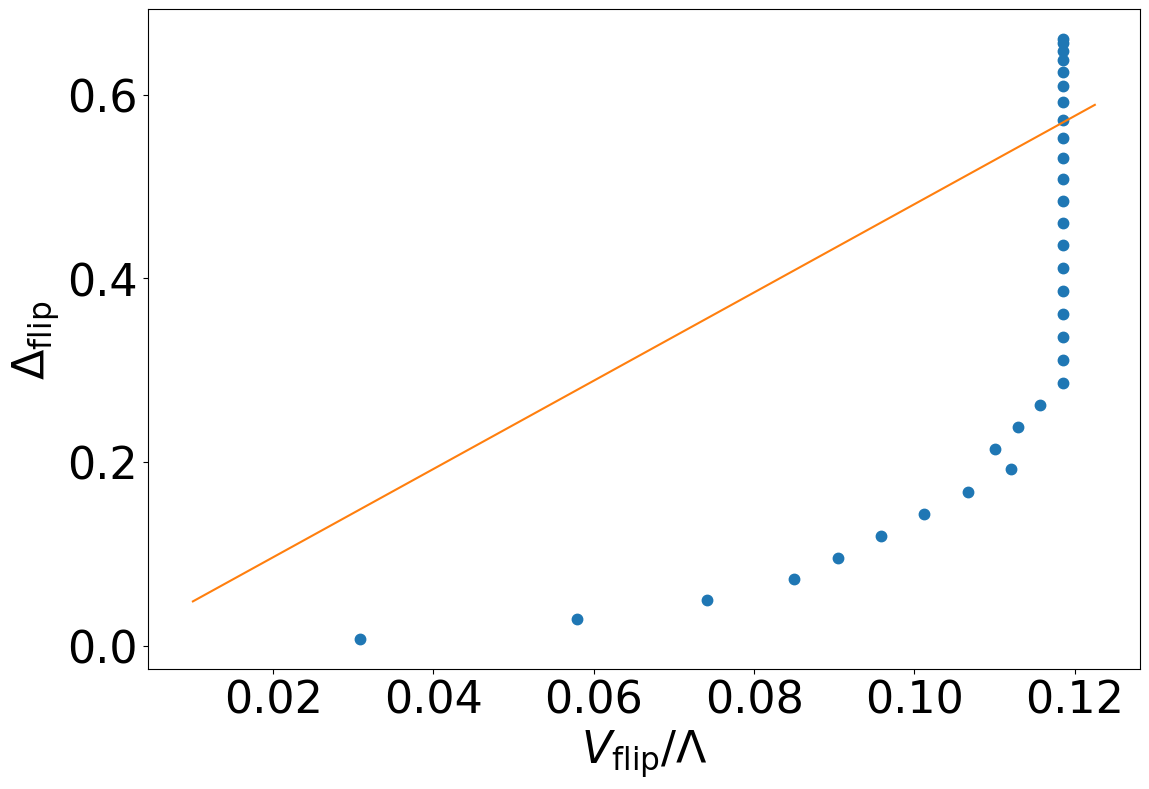

In [13]:


from scipy.stats import linregress
# Perform linear regression
slope, intercept, r_value, p_value, std_err = linregress(V_flip1, np.sqrt(gap_suscept1))



print(slope, intercept, r_value)

fig, ax = plt.subplots(figsize=(12, 8))
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'

V_lin = np.linspace(0.01, (V_flip1).max()+0.005, 100)

ax.plot(V_flip_all, gap_suscept_all, '.',markersize=15)
ax.plot(V_lin, slope * V_lin, label="Fit")
# ax.plot(V_lin/2, np.e**(slope*V_lin +intercept), label="Fit")
# plt.yscale('log')
ax.tick_params(axis='x', labelsize=32)
ax.tick_params(axis='y', labelsize=32)
plt.xlabel(r"$V_{\rm flip}/\Lambda$", fontsize=32)
plt.ylabel(r"$\Delta_{\rm flip}$", fontsize=32)
plt.tight_layout()
plt.savefig("panelsCurrentNoise/Gap_Vflip_extendend.png", bbox_inches='tight', dpi=600)

In [14]:

hstep = 1e-5
omegaSpace = np.array([1e-5])
n_points = 60

PiR_ZeroV = np.zeros(n_points, dtype=np.complex128)

lambdaUpper = lambdaSamples[0]
pbar = tqdm(total=n_points, desc='Computing PiR')


voltageSpace_ZeroV = np.array([0.0]*n_points)
Tspace_ZeroV = np.linspace(T_flip_all.min(), T_flip_all.max(), n_points)


for i in range(n_points):
    Tvalue = Tspace_ZeroV[i]
    voltageValue = voltageSpace_ZeroV[i]
    phiValue = computeSaddlePoint(lambdaUpper, Tvalue, voltageValue)
    PiR_ZeroV[i:] = Susceptv2.computePiR(omegaSpace, lambdaUpper, phiValue, voltageValue, couplingValue, Tvalue=Tvalue)
    pbar.update(1)

pbar.close()

XR_ZeroV = computeXR(PiR_ZeroV, lambdaUpper)
gap_ZeroV = np.reciprocal(XR_ZeroV).real


Computing PiR: 100%|██████████| 60/60 [00:04<00:00, 12.44it/s]


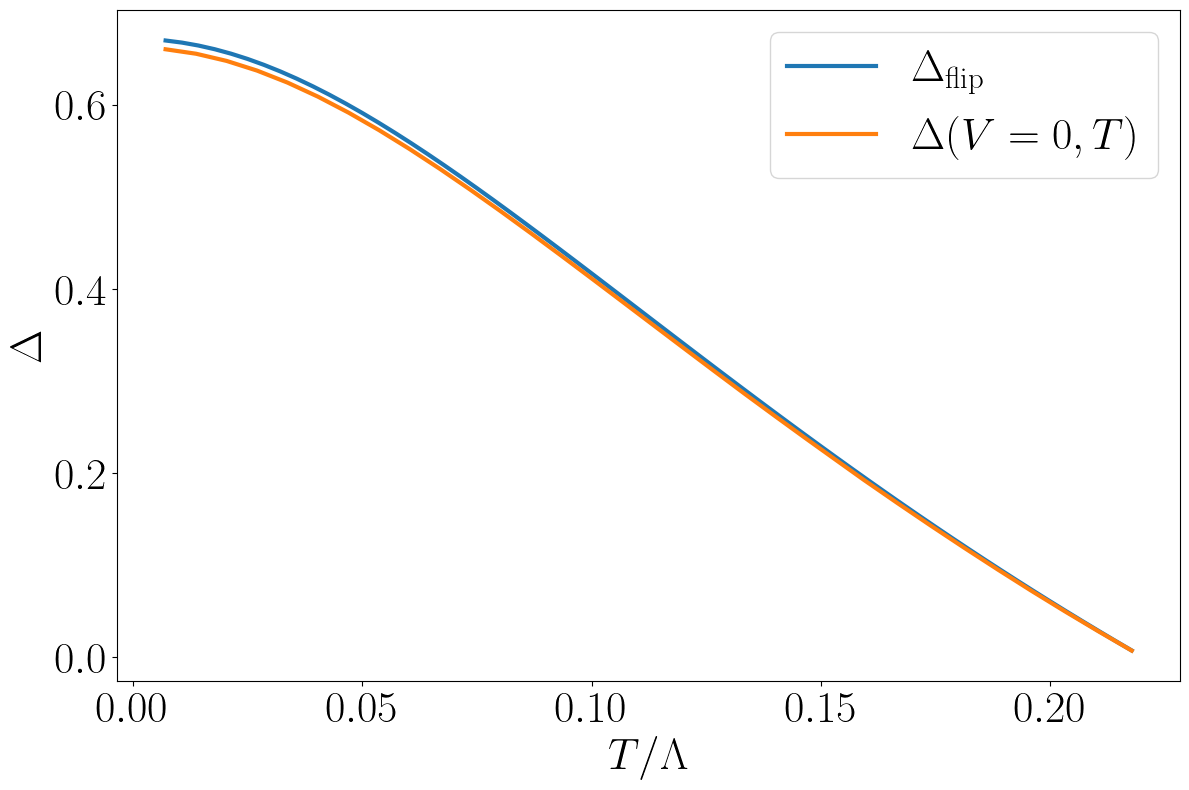

In [15]:
fig, ax = plt.subplots(figsize=(12, 8))
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'

# ax.plot(V_flip_all/2, gap_suscept_all, '.',markersize=15)
ax.plot(Tspace_ZeroV/2, gap_ZeroV, markersize=20, label=r"$\Delta_{\rm flip}$", linewidth=3)
ax.plot(T_flip_all/2, gap_suscept_all, markersize=15, label=r"$\Delta(V=0, T)$", linewidth=3)
ax.tick_params(axis='x', labelsize=32)
ax.tick_params(axis='y', labelsize=32)
plt.xlabel(r"$T/\Lambda$", fontsize=32)
plt.ylabel(r"$\Delta$", fontsize=32)
plt.legend(fontsize=32)
plt.tight_layout()
plt.savefig("panelsCurrentNoise/Gaps_vs_T.png", bbox_inches='tight', dpi=600)

In [16]:
hstep = 1e-5
omegaSpace = np.array([1e-5])
n_points = 40

PiR_ZeroT = np.zeros(n_points, dtype=np.complex128)

lambdaUpper = lambdaSamples[0]

pbar = tqdm(total=n_points, desc='Computing PiR')


voltageSpace_ZeroT = np.linspace(1.0, 0.0, n_points)
Tspace_ZeroT = np.array([1e-4] * n_points)

for i in range(n_points):
    Tvalue = Tspace_ZeroT[i]
    voltageValue = voltageSpace_ZeroT[i]
    phiValue = computeSaddlePoint(lambdaUpper, Tvalue, voltageValue)
    PiR_ZeroT[i:] = Susceptv2.computePiR(omegaSpace, lambdaUpper, phiValue, voltageValue, couplingValue, Tvalue=Tvalue)
    pbar.update(1)

pbar.close()


XR_ZeroT = computeXR(PiR_ZeroT, lambdaUpper)
gap_ZeroT = np.reciprocal(XR_ZeroT).real


Computing PiR: 100%|██████████| 40/40 [00:02<00:00, 13.86it/s]


In [17]:


hstep = 1e-5
omegaSpace = np.array([1e-5])
n_points = len(V_flip_all)

PiR_ZeroV2 = np.zeros(n_points, dtype=np.complex128)
lambdaUpper = lambdaSamples[0]
pbar = tqdm(total=n_points, desc='Computing PiR')


for i in range(n_points):
    Tvalue = T_flip_all[i]
    voltageValue = 0
    phiValue = computeSaddlePoint(lambdaUpper, Tvalue, voltageValue)
    PiR_ZeroV2[i:] = Susceptv2.computePiR(omegaSpace, lambdaUpper, phiValue, voltageValue, couplingValue, Tvalue=Tvalue)
    pbar.update(1)

pbar.close()

XR_ZeroV2 = computeXR(PiR_ZeroV2, lambdaUpper)
gap_ZeroV2 = np.reciprocal(XR_ZeroV2).real


Computing PiR:   0%|          | 0/32 [00:00<?, ?it/s]

Computing PiR: 100%|██████████| 32/32 [00:02<00:00, 11.41it/s]


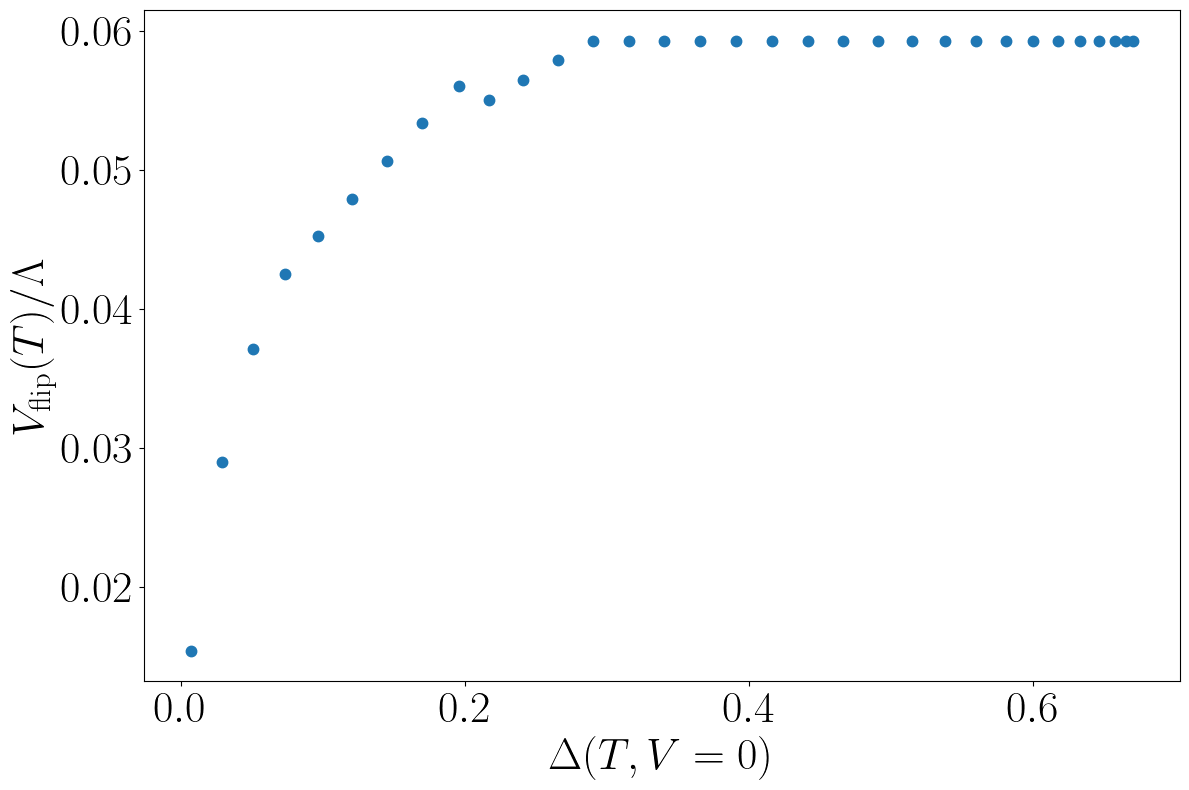

In [18]:

fig, ax = plt.subplots(figsize=(12, 8))
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'

ax.plot(gap_ZeroV2, V_flip_all/2, '.',markersize=15)

ax.tick_params(axis='x', labelsize=32)
ax.tick_params(axis='y', labelsize=32)
plt.ylabel(r"$V_{\rm flip}(T)/\Lambda$", fontsize=32)
plt.xlabel(r"$\Delta(T,V=0)$", fontsize=32)
plt.tight_layout()
plt.savefig("panelsCurrentNoise/Vflip_vs_Gap.png", bbox_inches='tight', dpi=600)